In [2]:
print("Hello, world")

Hello, world


In [3]:
!pip install numpy
!pip install --use-pep517 faiss-cpu
!pip install fastparquet
!pip install --user matplotlib
!pip install phik

In [4]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

import phik
from phik.report import plot_correlation_matrix
from phik import report

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [5]:
#from joblib.parallel import parallel_config
from joblib import parallel

import os
os.environ['JOBLIB_TEMP_FOLDER'] = 'F:/tmp/'


## Load data

### Base data

In [6]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_validation = dict_base.copy()
dict_train['Target'] = 'str'

In [7]:
df_base = pd.read_csv("../data/base.csv", index_col=0, dtype=dict_base)
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


### Train data

In [8]:
df_train = pd.read_csv("../data/train.csv", index_col=0, dtype=dict_train)
df_train.shape

(100000, 73)

In [9]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,...,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,...,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,...,45.028912,-196.092072,-117.626335,66.926224,42.456169,77.621765,92.479927,-1074.464844,-21.149351,717819-base


In [10]:
df_validation = pd.read_csv("../data/validation.csv", index_col=0, dtype=dict_validation)
df_validation.shape

(100000, 72)

In [11]:
df_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,...,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,...,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,...,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,...,-123.770248,45.635944,-134.258926,13.735359,70.617630,15.332115,154.568115,101.700638,-1171.892334,-125.307892


In [12]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

In [13]:
df_validation_answer = pd.read_csv("../data/validation_answer.csv", index_col=0)
df_validation_answer.shape

(100000, 1)

In [14]:
df_validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


## EDA

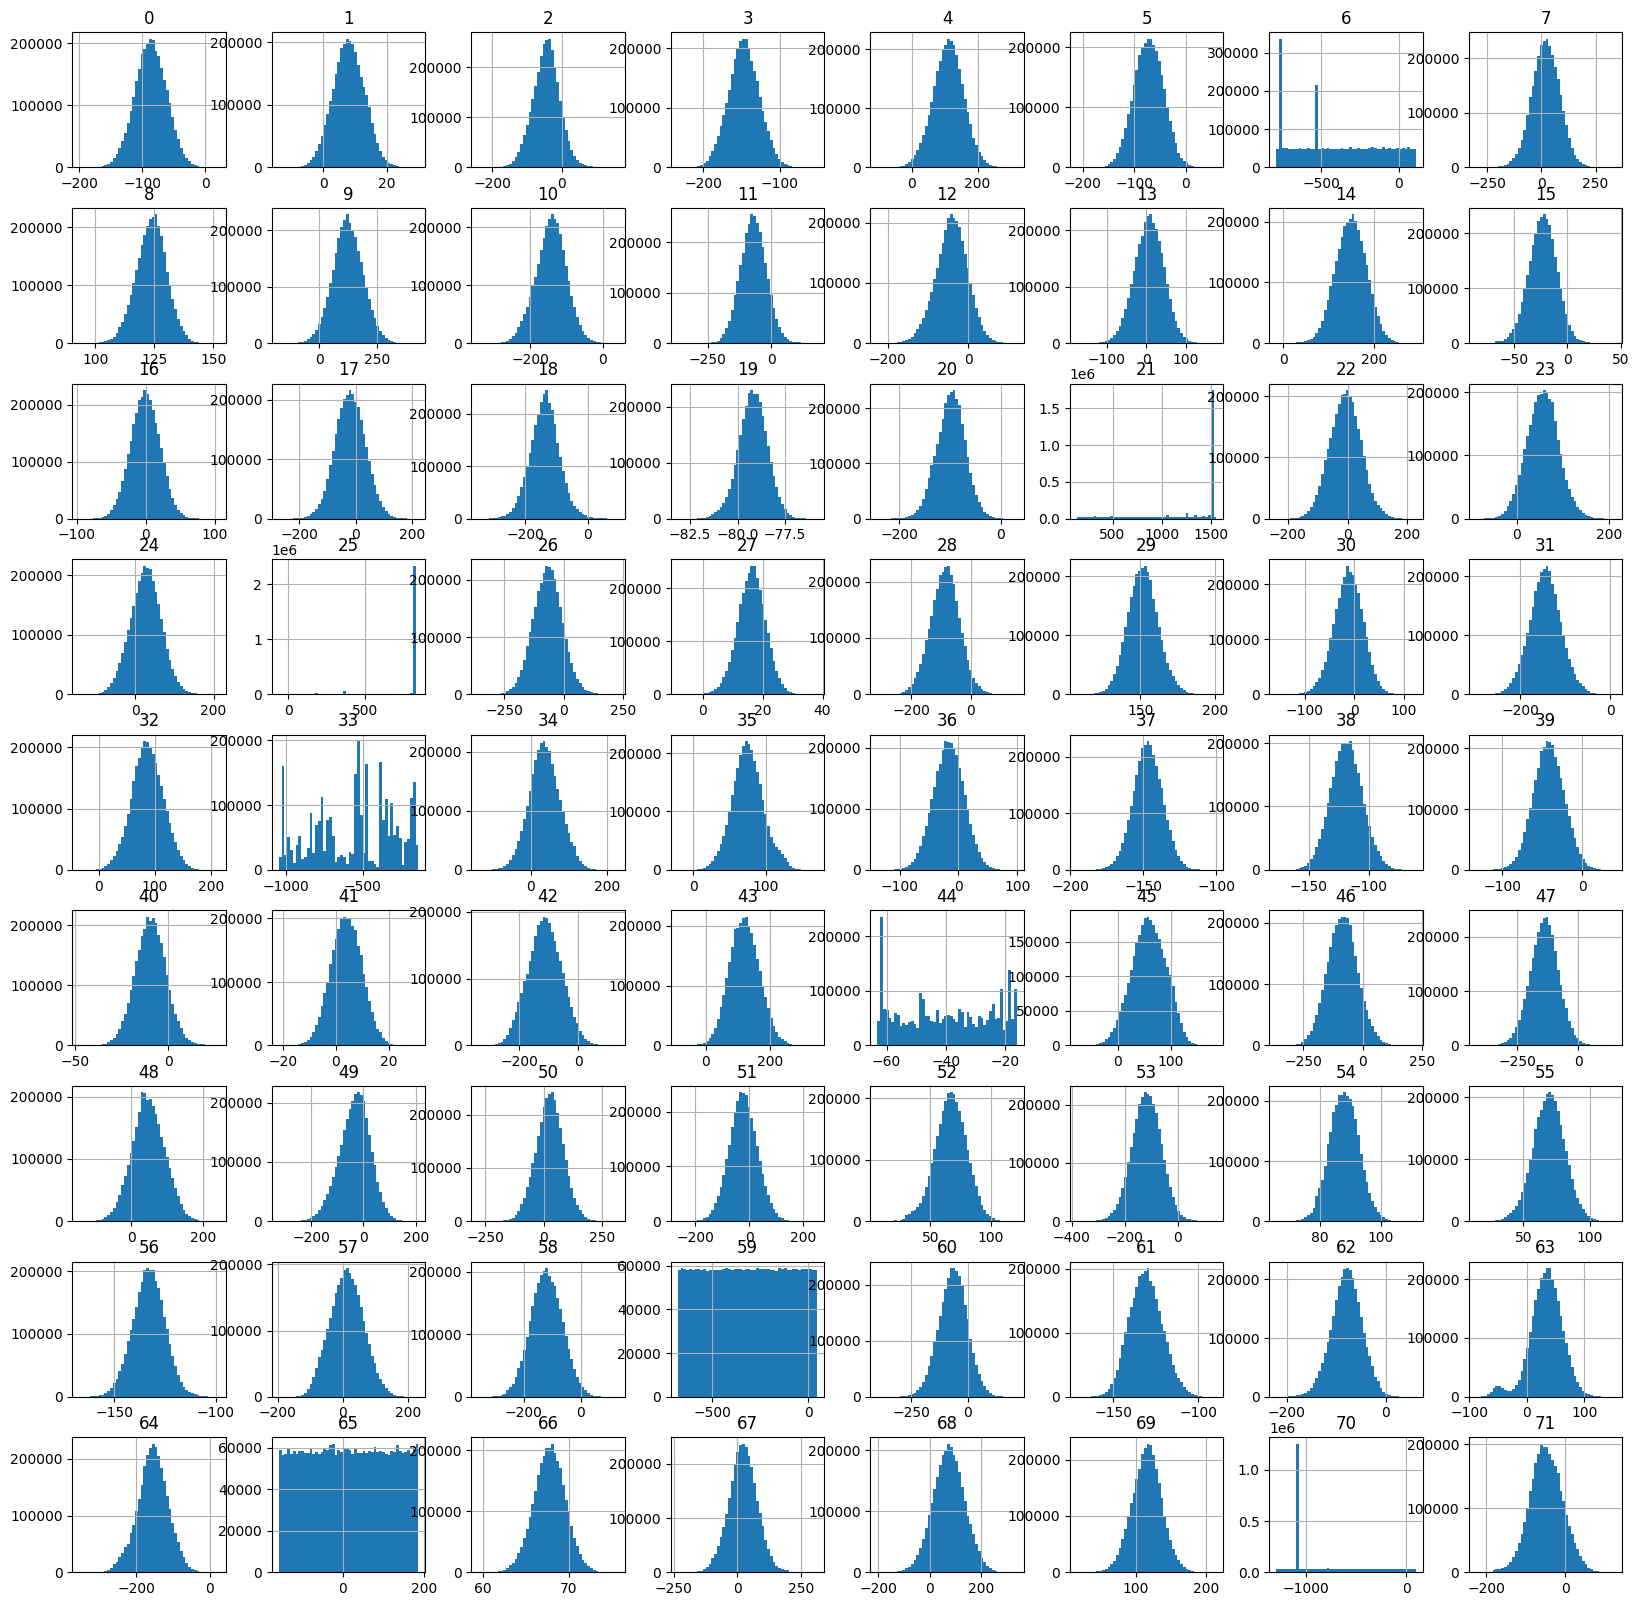

In [15]:
df_base.hist(figsize=[20, 20], bins=50);

In [16]:
strange_features = ["6", "21", "25", "33", "44", "59", "65", "70"]

array([[<Axes: title={'center': '6'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '25'}>],
       [<Axes: title={'center': '33'}>, <Axes: title={'center': '44'}>,
        <Axes: title={'center': '59'}>],
       [<Axes: title={'center': '65'}>, <Axes: title={'center': '70'}>,
        <Axes: >]], dtype=object)

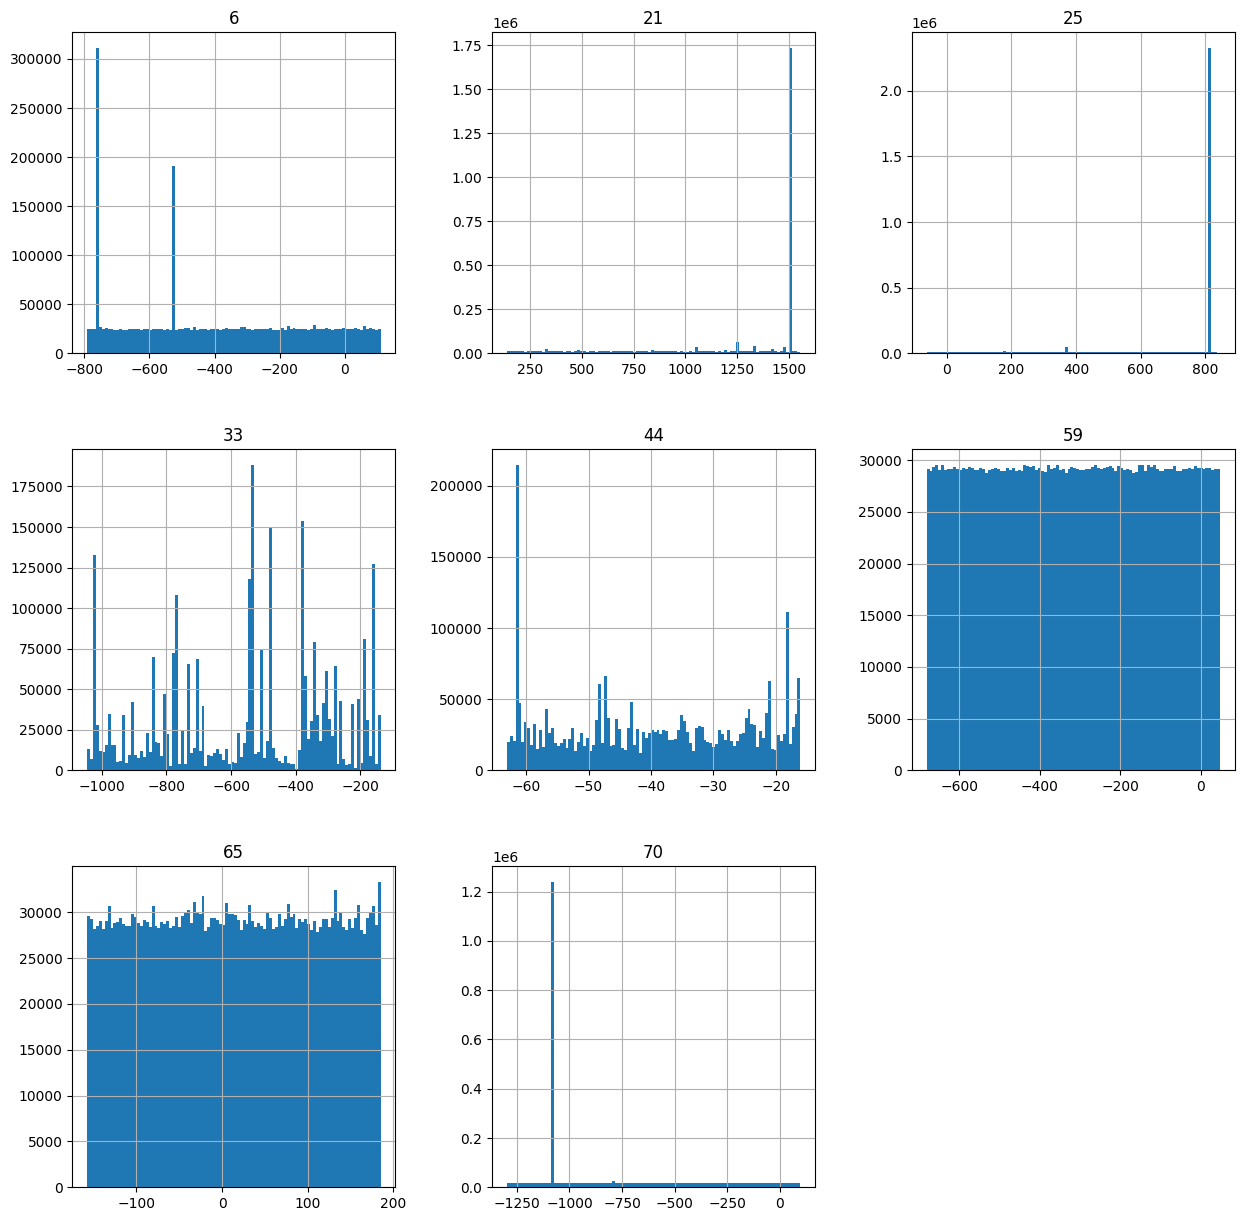

In [17]:
df_base[strange_features].hist(figsize=[15, 15], bins=100)


Фичи 6, 59,65 выглядят интересно в плане распределения. Возможно, данные фичи связаны с какими-то стандартными величинами, типа размера упаковки или чего-то подобного.
Несмотря на то, что у 6 фичи есть явный выброс, ее можно оставить и создать новую категориальную фичу.
59 и 65 - так же выглядят, как кандидаты для категоризации.

Фичи 33 и 44 - распеределение не особо радует, поэтому категоризурем данные фичи.

Фичи 21, 25, 70 - по идее, тоже можно было бы категоризовать, но у них есть сильный выбросы, что скорее всего помешает обучению.
Данные фичи нужно исключить из выборки.

Итого. 
--21, 25, 70 - удаляем из выборке.--

6, 59, 65,33 и 44 - сотавляем для дальнейшего анализа.

In [18]:
#df_base = df_base.drop(columns=["21", "25", "70"])
#df_train = df_train.drop(columns=["21", "25", "70"])

### Phik Correlations

In [19]:
if False:
    phik_corrs = df_base.sample(50000).phik_matrix()

In [20]:
%%time
if False:
    plot_correlation_matrix(phik_corrs.values, 
                            x_labels=phik_corrs.columns, 
                            y_labels=phik_corrs.index, 
                            vmin=0, vmax=1, color_map="Blues", 
                            title=r"correlation $\phi_K$", 
                            fontsize_factor=1.5, 
                            figsize=(60, 60))
    plt.show()

CPU times: total: 0 ns
Wall time: 0 ns


Отрицательный результат, тоже результат.
По большоей части, ни каких корреляция между фичами нет, а значит и сильной мультиколлинеарности тоже не будет.
Оставяем данные, как есть.

## Gauss Rank

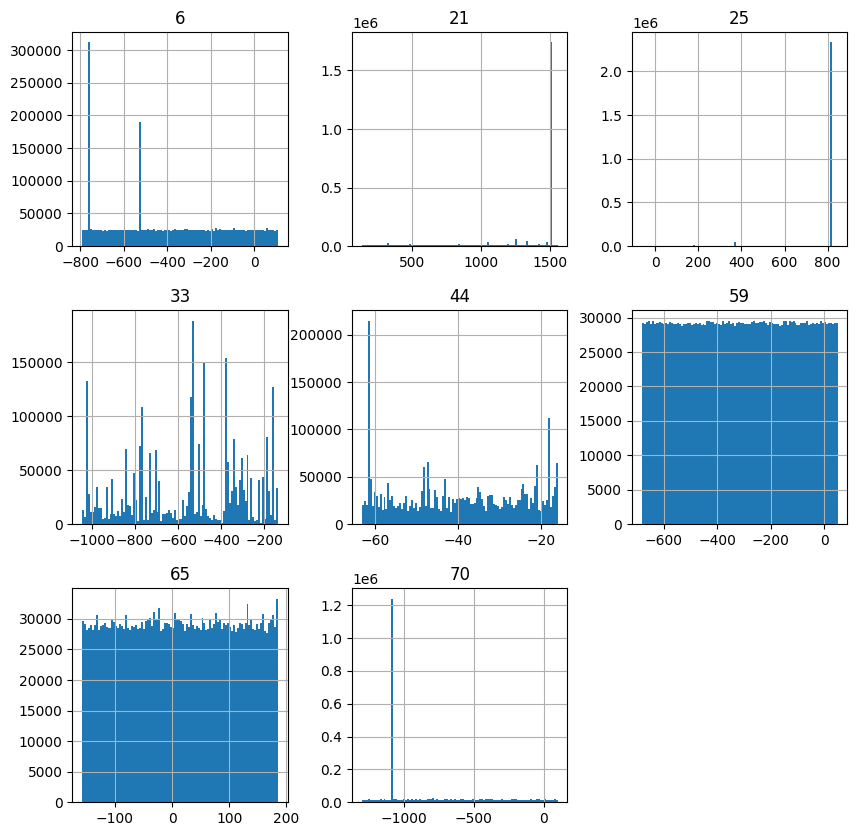

In [21]:
analyze_features = strange_features.copy()
df_base[analyze_features].hist(figsize=[10, 10], bins=100)
plt.show()

### Feature ranking

In [22]:
def toGauss(base, train, validation, column):
    quantile = QuantileTransformer(random_state=42, output_distribution='normal')
    base_feature = base[column].values.reshape((len(base[column]),1))
    train_feature = train[column].values.reshape((len(train[column]),1))
    validation_feature = train[column].values.reshape((len(validation[column]),1))

    quantile.fit(base_feature)
    base_feature_normal = quantile.transform(base_feature)
    train_feature_normal = quantile.transform(train_feature)
    validation_feature_normal = quantile.transform(validation_feature)

    tbase = base.copy().reset_index()
    ttrain = train.copy().reset_index()
    tvalidation = validation.copy().reset_index()

    tbase[column+"_normal"] = pd.Series(base_feature_normal.reshape((len(base_feature_normal), 1)[0]))
    ttrain[column+"_normal"] = pd.Series(train_feature_normal.reshape((len(train_feature_normal), 1)[0]))
    tvalidation[column+"_normal"] = pd.Series(validation_feature_normal.reshape((len(validation_feature_normal), 1)[0]))
    
    tbase.set_index("Id", inplace=True)
    ttrain.set_index("Id", inplace=True)
    tvalidation.set_index("Id", inplace=True)

    
    return tbase, ttrain, tvalidation

### 33 feature

In [23]:
for i in analyze_features:
    df_base, df_train, df_validation = toGauss(df_base, df_train, df_validation, i)

In [24]:
check_resullts = [i + "_normal" for i in analyze_features] + analyze_features

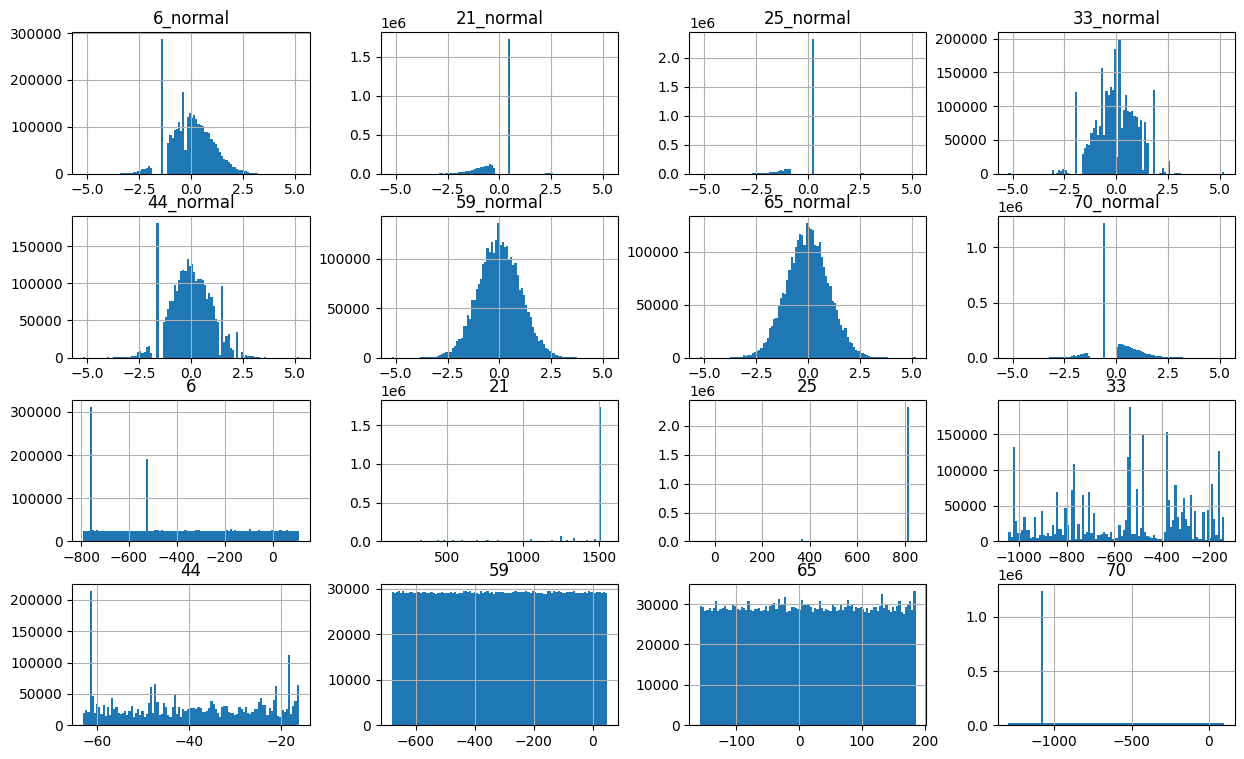

In [25]:
df_base[check_resullts].hist(bins=100, figsize=(15, 9))
plt.show()

In [26]:
df_base = df_base.drop(columns=analyze_features)
df_train = df_train.drop(columns=analyze_features)
df_validation = df_validation.drop(columns=analyze_features)

In [27]:
rename_list = {}
for i in analyze_features:
    rename_list[i+"_normal"] = f"{i}"
rename_list

{'6_normal': '6',
 '21_normal': '21',
 '25_normal': '25',
 '33_normal': '33',
 '44_normal': '44',
 '59_normal': '59',
 '65_normal': '65',
 '70_normal': '70'}

In [28]:
df_base = df_base.rename(columns=rename_list)
df_train = df_train.rename(columns=rename_list)
df_validation = df_validation.rename(columns=rename_list)

## Save data

In [ ]:
df_base.to_parquet("../tmp/cleared_df_base_new_features.parquet", compression="gzip")

df_train.to_parquet("../tmp/cleared_df_train_new_features.parquet", compression="gzip")

df_validation.to_parquet("../tmp/cleared_df_validation_new_features.parquet", compression="gzip")